### Use Random Forest to prepare a model on fraud data treating those who have taxable_income <= 30000 as "Risky" and others are "Good"

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets  
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import  DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report,confusion_matrix,accuracy_score
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

In [2]:
# loade the data
fraud_data=pd.read_csv('Fraud_check.csv')
fraud_data

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


### Data Exploration

In [3]:
#Checking for null vcalues
fraud_data.isnull().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

In [4]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [5]:
#Checking for duplicate values
fraud_data[fraud_data.duplicated()] 

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban


In [6]:
fraud_data.describe()

,Taxable.Income,City.Population,Work.Experience
count,600.000000,600.000000,600.000000
mean,55208.375000,108747.368333,15.558333
std,26204.827597,49850.075134,8.842147
min,10003.000000,25779.000000,0.000000
25%,32871.500000,66966.750000,8.000000
50%,55074.500000,106493.500000,15.000000
75%,78611.750000,150114.250000,24.000000
max,99619.000000,199778.000000,30.000000


As we show that the data are not in the same scale. So, to bring it in same scale we should standardize it in pre-processing.

In [7]:
# Converting taxiabl income  in categorical as mention in question
fraud_data['Taxable.Income'].describe()

count      600.000000
mean     55208.375000
std      26204.827597
min      10003.000000
25%      32871.500000
50%      55074.500000
75%      78611.750000
max      99619.000000
Name: Taxable.Income, dtype: float64

In [8]:
# Converting the Target column i.e. Taxable Income into Categorical value
data=fraud_data.copy()
tax_val = []
for value in fraud_data["Taxable.Income"]:
 if value<=30000:
    tax_val.append("Risky")
 else:
    tax_val.append("Good")
data["tax_val"]= tax_val
data.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban,tax_val
0,NO,Single,68833,50047,10,YES,Good
1,YES,Divorced,33700,134075,18,YES,Good
2,NO,Married,36925,160205,30,YES,Good
3,YES,Single,50190,193264,15,YES,Good
4,NO,Married,81002,27533,28,NO,Good


In [9]:
data['tax_val'].value_counts()

Good     476
Risky    124
Name: tax_val, dtype: int64

In [10]:
# List of Numerical Variables 
numerical_features = data.describe(include=["int64","float64"]).columns
numerical_features

Index(['Taxable.Income', 'City.Population', 'Work.Experience'], dtype='object')

In [11]:
# categorical variables 
categorical_features = data.describe(include=["object"]).columns
categorical_features

Index(['Undergrad', 'Marital.Status', 'Urban', 'tax_val'], dtype='object')

In [12]:
# check for cardinality in categorical variables
for var in categorical_features:
    print(var, ' contains ', len(data[var].unique()), ' labels')

Undergrad  contains  2  labels
Marital.Status  contains  3  labels
Urban  contains  2  labels
tax_val  contains  2  labels


As we show that labels are not must large so we shoud use dummies encoder to convert it in numeric


### Exploratory Data Analysis

In [13]:
# checking for correlation
data.corr()

,Taxable.Income,City.Population,Work.Experience
Taxable.Income,1.000000,-0.064387,-0.001818
City.Population,-0.064387,1.000000,0.013135
Work.Experience,-0.001818,0.013135,1.000000


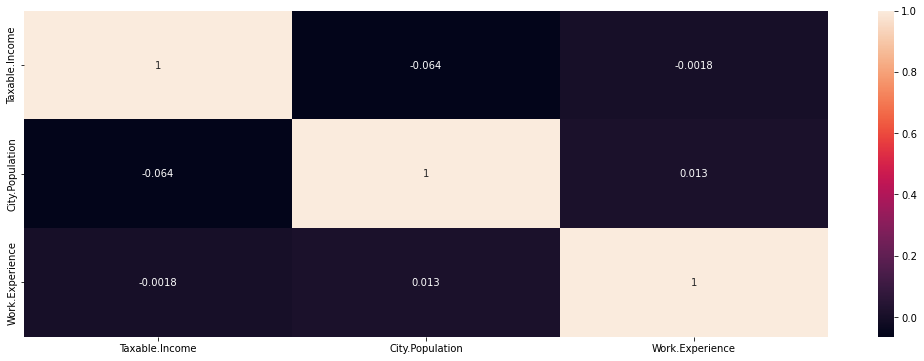

In [14]:
# Heatmap visualization
fig= plt.figure(figsize=(18, 6))
sns.heatmap(data.corr(), annot=True);

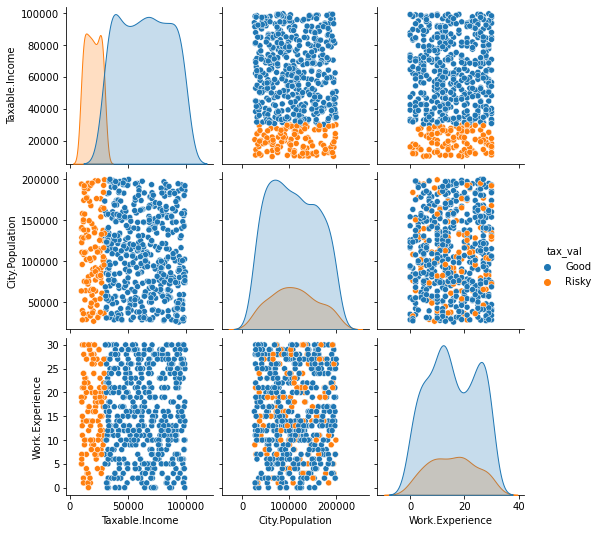

In [15]:
# pair plot data 
sns.pairplot(data=data,hue='tax_val')


By visualization of heatmap and pair plot we say that their are no correlation between features.

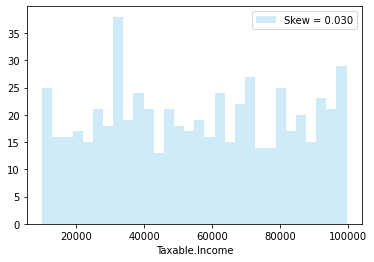

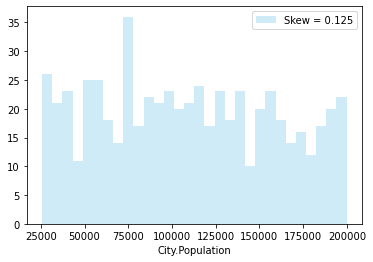

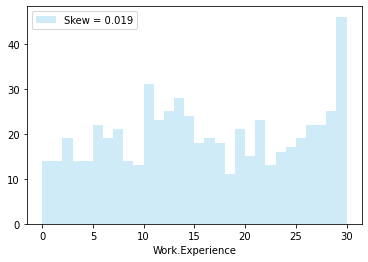

In [16]:
# Histogram visualization of numeric variables
for feat in numerical_features:
    skew = data[feat].skew()
    sns.distplot(data[feat], kde= False,color='skyblue', label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()


None of the features is normally distributed.Advertising have high skew so we shoud check for outliers by ploting boxplot.

<AxesSubplot:xlabel='Work.Experience'>

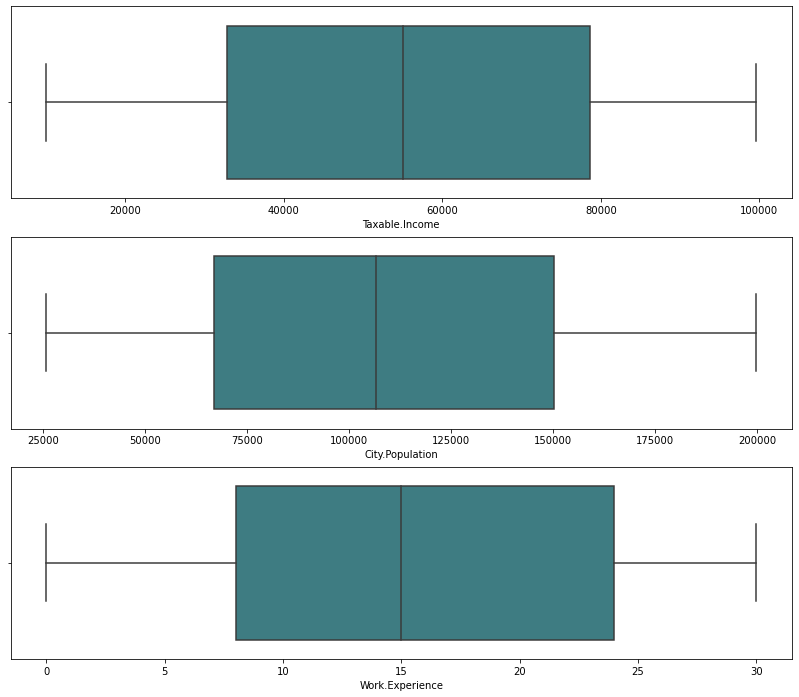

In [17]:
# Checking for outliers
fig, axes=plt.subplots(3,1,squeeze=True,figsize=(14,12),sharex=False,sharey=False)
sns.boxplot(x='Taxable.Income',data=data,palette='crest',ax=axes[0])
sns.boxplot(x='City.Population',data=data,palette='crest',ax=axes[1])
sns.boxplot(x='Work.Experience',data=data,palette='crest',ax=axes[2])


Their is no outlier present in the dataset

<AxesSubplot:xlabel='tax_val', ylabel='count'>

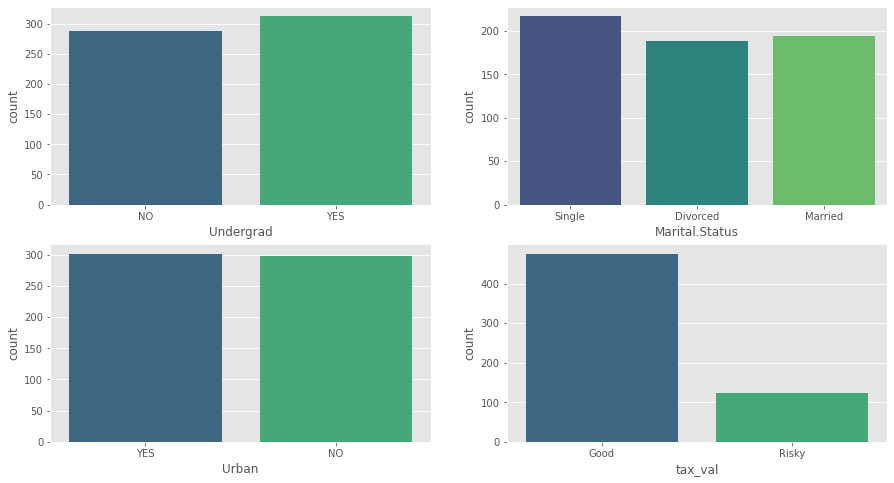

In [18]:
# countplot for visualization for categorical data
plt.style.use("ggplot")
fig, ax =plt.subplots(2,2, figsize=(15,8)) 
sns.countplot(data["Undergrad"], palette="viridis", ax=ax[0,0])
sns.countplot(data["Marital.Status"], palette="viridis", ax=ax[0,1])
sns.countplot(data["Urban"], palette="viridis", ax=ax[1,0])
sns.countplot(data["tax_val"], palette="viridis", ax=ax[1,1])

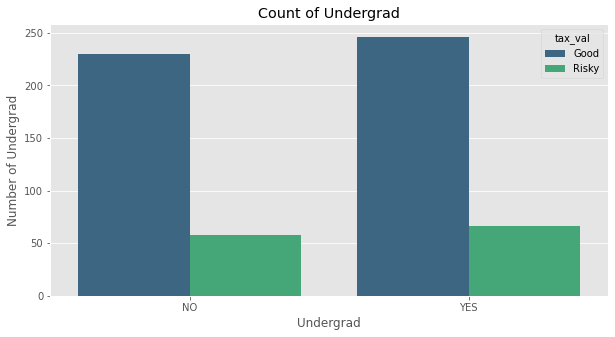

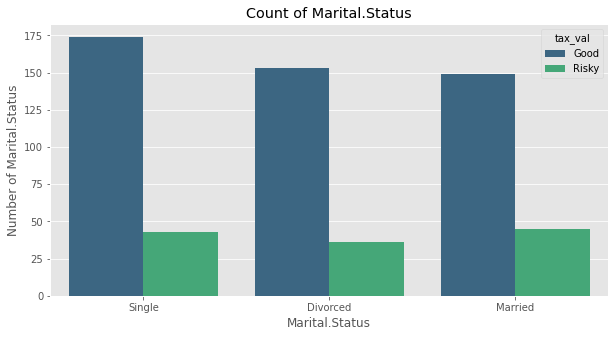

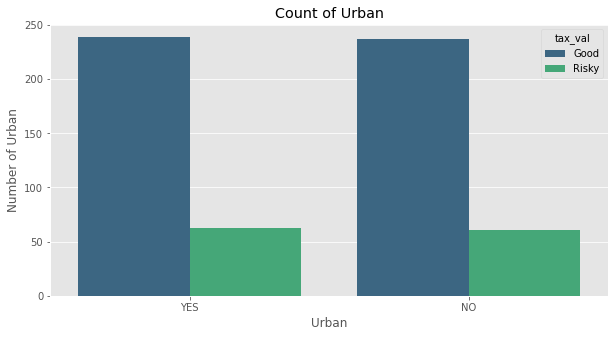

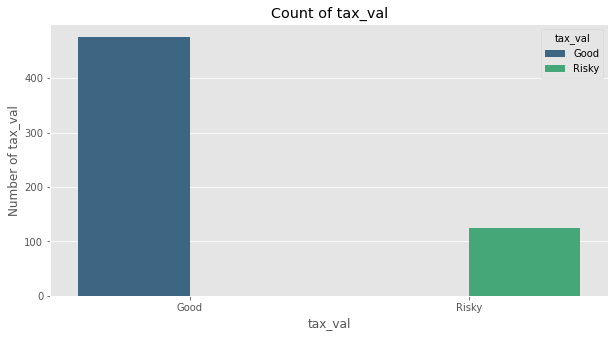

In [19]:
# visualization of categorical data w.r.t. Sales_cat
for var,column in enumerate(categorical_features):
    plt.figure(figsize=(10, 5))
    unique = data[column].value_counts(ascending=True);   
    plt.title("Count of "+ column)
    sns.countplot(data=data, x=column,palette = "viridis",hue='tax_val')
    plt.xlabel(column)
    plt.ylabel("Number of "+ column)

Preson belonging to urbon and non-urbon are almost same and the risk value are for every feature are low 

### Checking for imblance and balanced dataset

In [20]:
data['tax_val'].value_counts()

Good     476
Risky    124
Name: tax_val, dtype: int64

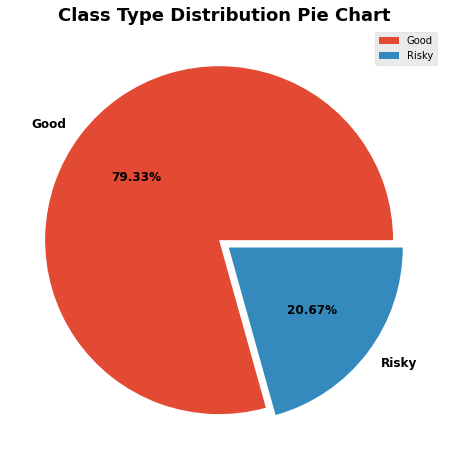

In [21]:
# pie plot for tax_val
plt.figure(figsize = (12,8))
plt.pie(data['tax_val'].value_counts(),labels=data.tax_val.unique(),explode = [0.04,0.03],autopct= '%.2f%%',
       textprops = {'size':'large','fontweight':'bold','rotation':'0','color':'black'})
plt.legend(loc= 'upper right')
plt.title("Class Type Distribution Pie Chart", fontsize = 18, fontweight = 'bold')
plt.show()

We have an imblance data.

## Data pre-processing

In [22]:
# Droping of unwanted columns
df= data.copy()
df.drop('Taxable.Income',axis=1, inplace =True)
df.head()

,Undergrad,Marital.Status,City.Population,Work.Experience,Urban,tax_val
0,NO,Single,50047,10,YES,Good
1,YES,Divorced,134075,18,YES,Good
2,NO,Married,160205,30,YES,Good
3,YES,Single,193264,15,YES,Good
4,NO,Married,27533,28,NO,Good


In [23]:
# use dummeis encoder for categorical features except target features 
df = pd.get_dummies(df.iloc[:,:-1])
df.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES
0,50047,10,1,0,0,0,1,0,1
1,134075,18,0,1,1,0,0,0,1
2,160205,30,1,0,0,1,0,0,1
3,193264,15,0,1,0,0,1,0,1
4,27533,28,1,0,0,1,0,1,0


In [24]:
# rename of column and apply label encoder to target variables
df['tax_val'] = data.tax_val
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df["tax_val"])
df["tax_val"]=le.transform(df["tax_val"])
df.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES,tax_val
0,50047,10,1,0,0,0,1,0,1,0
1,134075,18,0,1,1,0,0,0,1,0
2,160205,30,1,0,0,1,0,0,1,0
3,193264,15,0,1,0,0,1,0,1,0
4,27533,28,1,0,0,1,0,1,0,0


In [25]:
# Standardization of data
from sklearn.preprocessing import StandardScaler
x = df.drop('tax_val',axis=1)
y = df[['tax_val']]
sc = StandardScaler()
x_std = sc.fit_transform(x)
x_std

array([[-1.17852072, -0.62914254,  1.040833  , ...,  1.32852435,
        -0.99335541,  0.99335541],
       [ 0.50850002,  0.27636996, -0.96076892, ..., -0.75271484,
        -0.99335541,  0.99335541],
       [ 1.03310911,  1.63463872,  1.040833  , ..., -0.75271484,
        -0.99335541,  0.99335541],
       ...,
       [ 0.90969648, -1.76103318,  1.040833  , ..., -0.75271484,
        -0.99335541,  0.99335541],
       [ 1.43219749,  0.1631809 , -0.96076892, ..., -0.75271484,
         1.00668904, -1.00668904],
       [ 0.9915901 ,  0.04999184,  1.040833  , ..., -0.75271484,
         1.00668904, -1.00668904]])

In [26]:
# Train_test Split
x_train,x_test,y_train,y_test=train_test_split(x_std,y,test_size=0.3,random_state=0)
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((420, 9), (420, 1), (180, 9), (180, 1))

## Model bulding with imblance data

In [27]:
model_imblanced=RandomForestClassifier(random_state=42)
model_imblanced.fit(x_train,y_train)
y_train.value_counts()

tax_val
0          339
1           81
dtype: int64

In [28]:
pred_train_i = model_imblanced.predict(x_train)
print('Train data Accuracy :',accuracy_score(y_train,pred_train_i))
print('Train Report\n',classification_report(y_train,pred_train_i))
print('Confusion matrix of train \n',confusion_matrix(y_train,pred_train_i))

pred_test_i = model_imblanced.predict(x_test)
print('\n\nTest data Accuracy  :',accuracy_score(y_test,pred_test_i))
print('Test Report\n',classification_report(y_test,pred_test_i))
print('Confusion matrix of test \n',confusion_matrix(y_test,pred_test_i))


Train data Accuracy : 1.0
Train Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       339
           1       1.00      1.00      1.00        81

    accuracy                           1.00       420
   macro avg       1.00      1.00      1.00       420
weighted avg       1.00      1.00      1.00       420

Confusion matrix of train 
 [[339   0]
 [  0  81]]


Test data Accuracy  : 0.7222222222222222
Test Report
               precision    recall  f1-score   support

           0       0.76      0.93      0.84       137
           1       0.23      0.07      0.11        43

    accuracy                           0.72       180
   macro avg       0.50      0.50      0.47       180
weighted avg       0.63      0.72      0.66       180

Confusion matrix of test 
 [[127  10]
 [ 40   3]]


Due to imbalanced dataset our results are getting biased towards the majority. The model is correctly classifying all the majority classes yet fails to classify the minority classes. Hence, we need to use some kind of oversampling techniques to balance the dataset.

## Balance the Imblanced data using different technique

In [29]:
# Define function to build model for different technique 
def sampling(x_train,x_test,y_train,y_test):
    model=RandomForestClassifier(random_state=42)
    model.fit(x_train,y_train)
    pred_test_s=model.predict(x_test)
    print('Test classification Report\n',classification_report(y_test,pred_test_s))
    return()

#### Undersampling technique

In [30]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler()
x_under, y_under = undersample.fit_resample(x_std, y)
y_under.value_counts()

tax_val
0          124
1          124
dtype: int64

In [31]:
#spliting the new sample in train test
x_train,x_test,y_train,y_test=train_test_split(x_under,y_under,test_size=0.3,random_state=42,stratify=y_under)
# calling function
sampling(x_train,x_test,y_train,y_test)

Test classification Report
               precision    recall  f1-score   support

           0       0.49      0.55      0.52        38
           1       0.47      0.41      0.43        37

    accuracy                           0.48        75
   macro avg       0.48      0.48      0.48        75
weighted avg       0.48      0.48      0.48        75



()

#### Oversampling technique

In [32]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
x_over, y_over = oversample.fit_resample(x_std, y)
y_over.value_counts()

tax_val
0          476
1          476
dtype: int64

In [33]:
# spliting the new sample in train test
x_train,x_test,y_train,y_test=train_test_split(x_over,y_over,test_size=0.3,random_state=42,stratify=y_over)
# calling function
sampling(x_train,x_test,y_train,y_test)


Test classification Report
               precision    recall  f1-score   support

           0       0.93      0.73      0.82       143
           1       0.78      0.94      0.85       143

    accuracy                           0.84       286
   macro avg       0.85      0.84      0.84       286
weighted avg       0.85      0.84      0.84       286



()

#### SMOTE technique

In [34]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy='minority')
x_sm,y_sm = smote.fit_resample(x_std,y)
y_sm.value_counts()

tax_val
0          476
1          476
dtype: int64

In [35]:
# spliting data into train test
x_train,x_test,y_train,y_test=train_test_split(x_sm,y_sm,test_size=0.3,random_state=42,stratify=y_sm)
# calling function
sampling(x_train,x_test,y_train,y_test)

Test classification Report
               precision    recall  f1-score   support

           0       0.70      0.65      0.68       143
           1       0.68      0.73      0.70       143

    accuracy                           0.69       286
   macro avg       0.69      0.69      0.69       286
weighted avg       0.69      0.69      0.69       286



()

#### ADASYN Technique

In [36]:
from imblearn.over_sampling import ADASYN
adasyn=ADASYN(sampling_strategy='minority')
x_ad,y_ad = smote.fit_resample(x_std,y)
y_ad.value_counts()

tax_val
0          476
1          476
dtype: int64

In [37]:
# spliting data into train test
x_train,x_test,y_train,y_test=train_test_split(x_ad,y_ad,test_size=0.3,random_state=42,stratify=y_ad)
# calling function
sampling(x_train,x_test,y_train,y_test)

Test classification Report
               precision    recall  f1-score   support

           0       0.72      0.69      0.70       143
           1       0.70      0.73      0.71       143

    accuracy                           0.71       286
   macro avg       0.71      0.71      0.71       286
weighted avg       0.71      0.71      0.71       286



()

By implementing different techinique to balance the imblance data we find that oversampling gives the best result. 

## RandomForest Hyperparameter tuning

In [38]:
# split train test data with oversampling technique

x_train,x_test,y_train,y_test=train_test_split(x_over,y_over,test_size=0.3,random_state=42,stratify=y_over)


#### KFold Validation 

In [39]:
from sklearn.model_selection import KFold,cross_val_score
clf_tree = RandomForestClassifier(random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=None)

results = cross_val_score(clf_tree,x_std ,y , cv=cv)
print(results.mean())

0.7416666666666667


### 1  Randomized Search Cross Validation

In [40]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {'n_estimators':(list(range(1, 200))),
               'criterion':('gini', 'entropy'),
               'max_features': ('auto','sqrt','log2'),
               'max_depth': (list(range(1,4))),
               'min_samples_split':(list(range(1, 10))),
               'min_samples_leaf':(list(range(1, 10))), 
               'bootstrap':(True,False)}

rf_clf = RandomForestClassifier(random_state=42)

rf_cv = RandomizedSearchCV(estimator=rf_clf, scoring='accuracy',param_distributions=random_grid, n_iter=100, cv=cv, 
                               verbose=1, random_state=42, n_jobs=-1)

rf_cv.fit(x_train, y_train)
rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best paramters: {'n_estimators': 113, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': True})


### Model building using RandomSearchCV parameters

In [41]:
model_random=rf_cv.best_estimator_

#train test accuracy for checking overfitting and underfitting

pred_train_r = model_random.predict(x_train)
print('Train data Accuracy :',accuracy_score(y_train,pred_train_r))
print('Train Report\n',classification_report(y_train,pred_train_r))
print('Confusion matrix of train \n',confusion_matrix(y_train,pred_train_r))

pred_test_r = model_random.predict(x_test)
print('\n\nTest data Accuracy  :',accuracy_score(y_test,pred_test_r))
print('Test Report\n',classification_report(y_test,pred_test_r))
print('Confusion matrix of test \n',confusion_matrix(y_test,pred_test_r))


Train data Accuracy : 0.6966966966966966
Train Report
               precision    recall  f1-score   support

           0       0.72      0.64      0.68       333
           1       0.68      0.75      0.71       333

    accuracy                           0.70       666
   macro avg       0.70      0.70      0.70       666
weighted avg       0.70      0.70      0.70       666

Confusion matrix of train 
 [[213 120]
 [ 82 251]]


Test data Accuracy  : 0.5804195804195804
Test Report
               precision    recall  f1-score   support

           0       0.60      0.47      0.53       143
           1       0.57      0.69      0.62       143

    accuracy                           0.58       286
   macro avg       0.58      0.58      0.58       286
weighted avg       0.58      0.58      0.58       286

Confusion matrix of test 
 [[67 76]
 [44 99]]


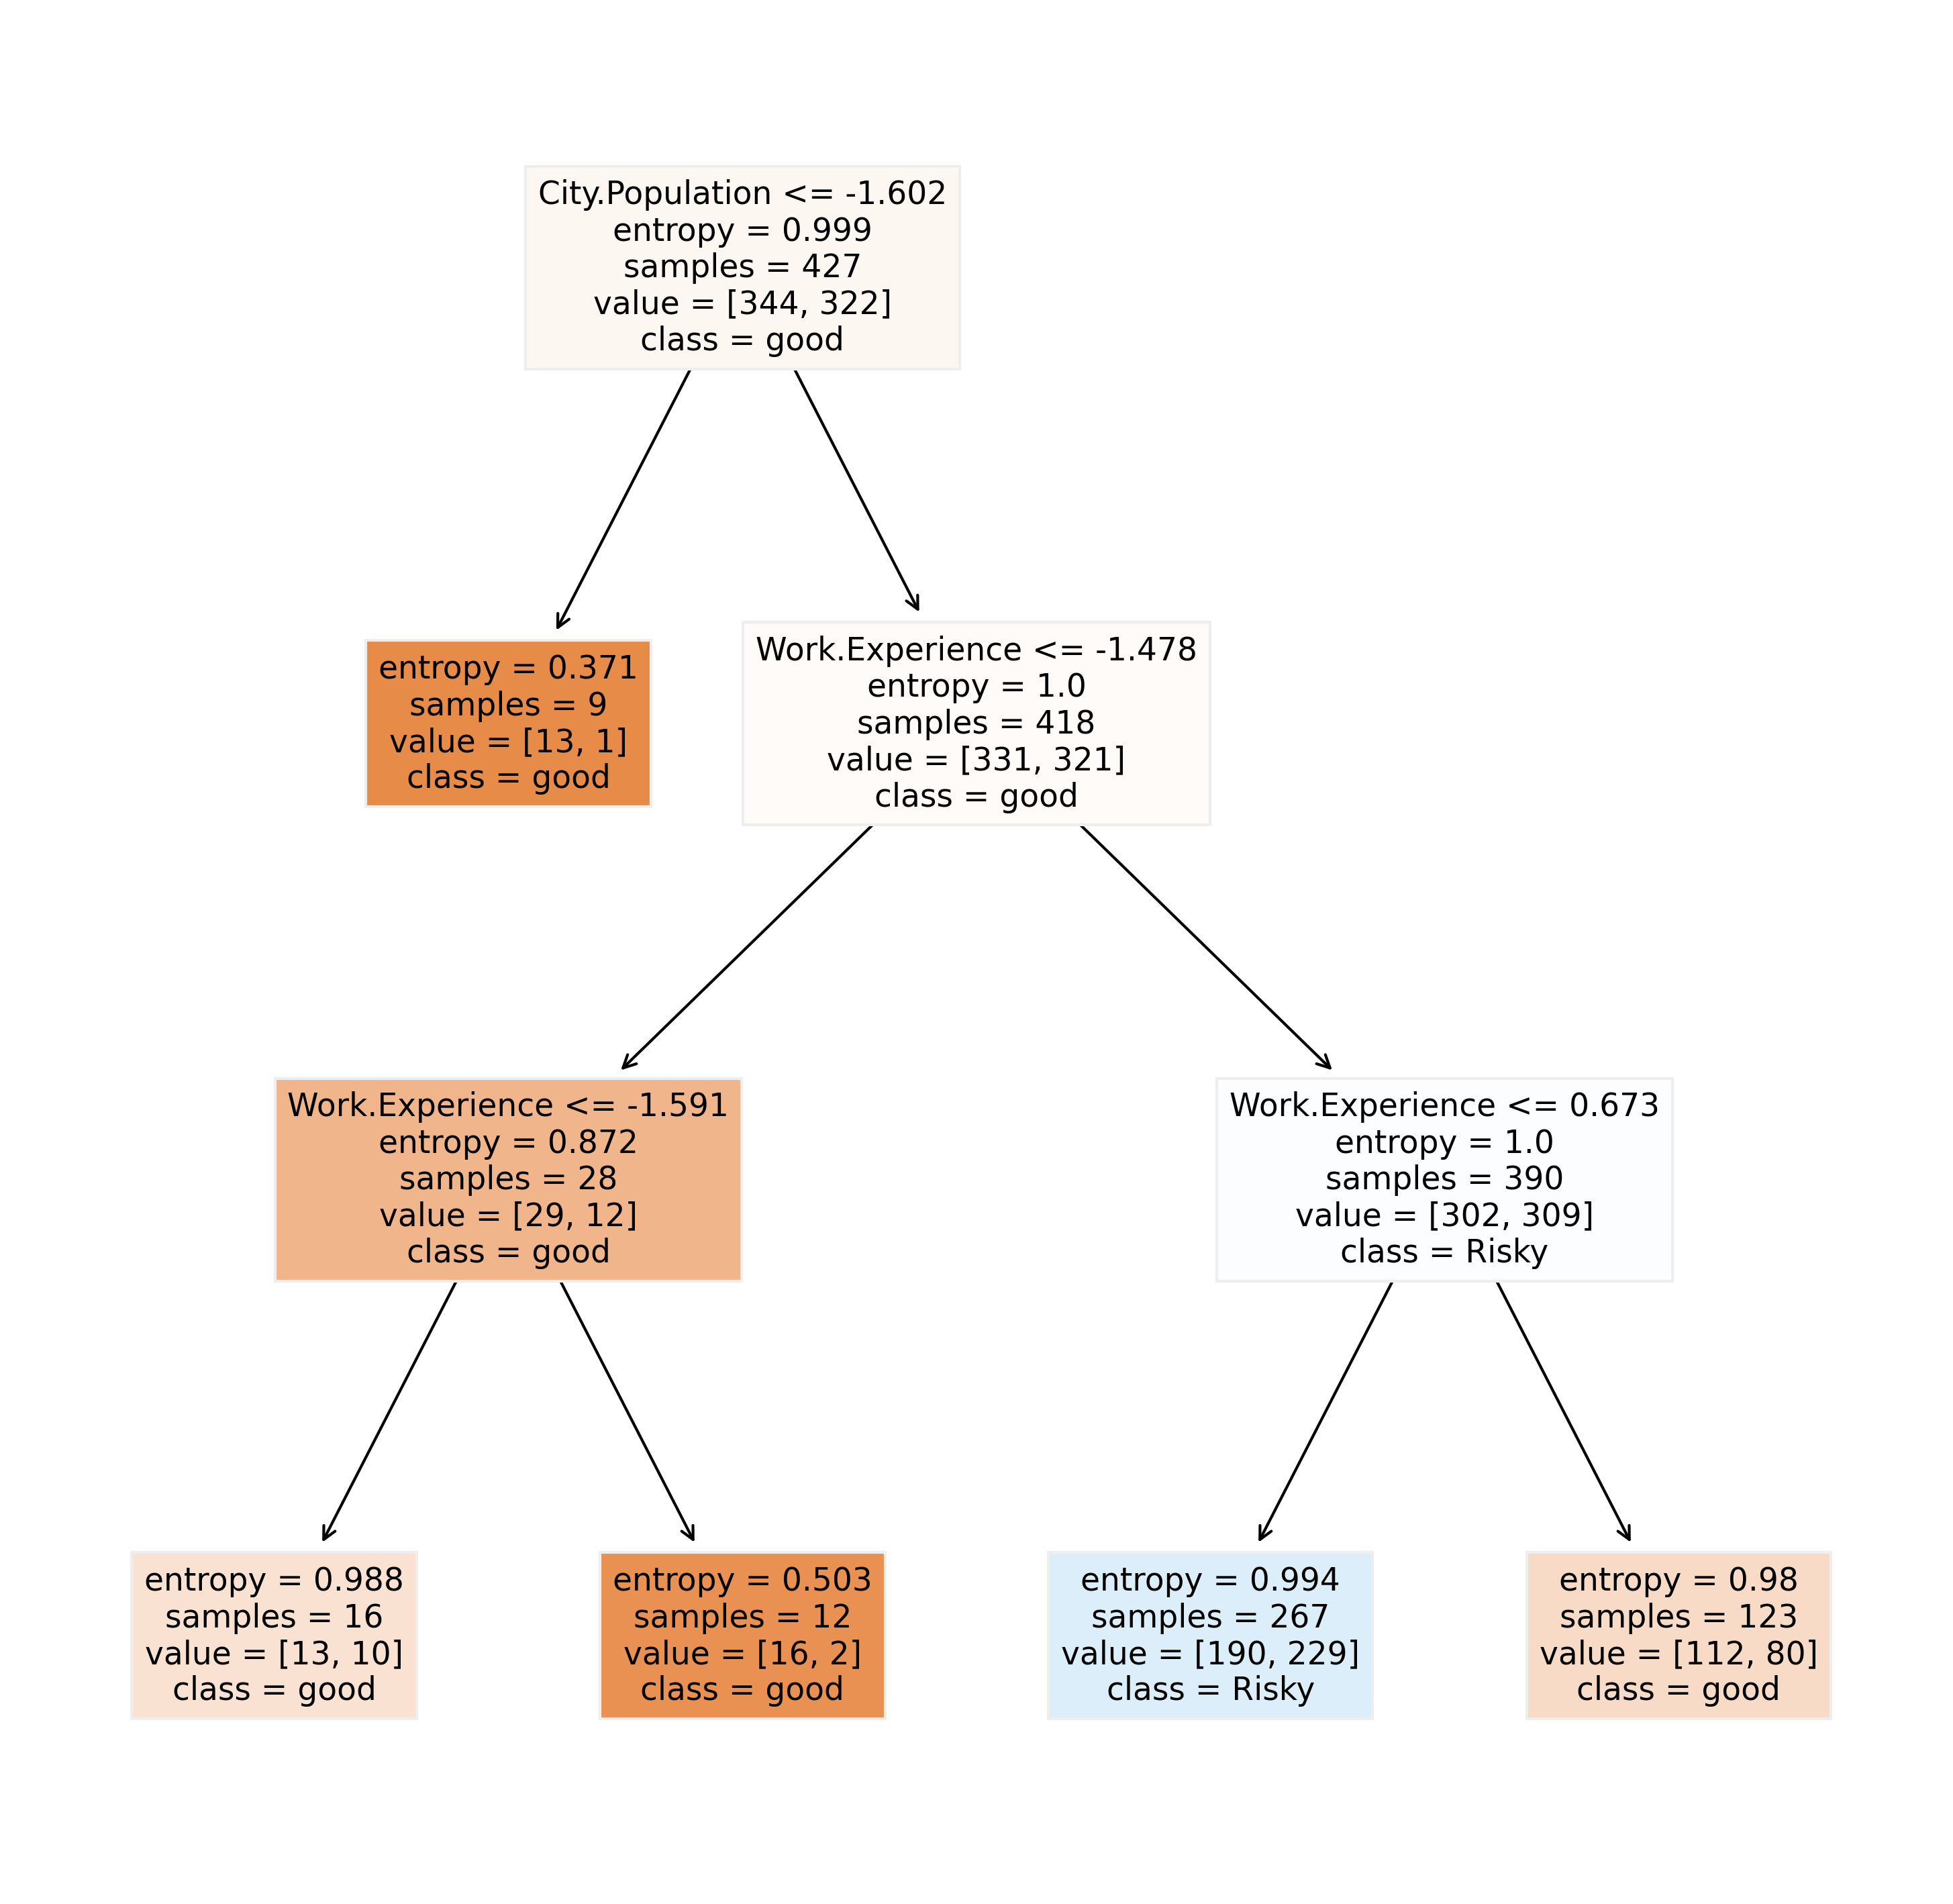

In [80]:
#PLot the decision tree
fn=['City.Population', 'Work.Experience', 'Undergrad', 'Marital.Status', 'Urban']
cn=['good','Risky']


fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (6,6), dpi=600)

tree.plot_tree(model_random.estimators_[9],feature_names = fn, class_names=cn,filled = True);

### 2 Grid Search Cross Validation

In [43]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators':(list(range(1, 100))),
               'max_features': ('auto','sqrt'),
               'max_depth': (list(range(1, 4))),
               }

model_grid = RandomForestClassifier()
clf_grid=GridSearchCV(model_grid, param_grid,scoring="accuracy", n_jobs=-1, verbose=1, cv=cv,return_train_score=False)
clf_grid.fit(x_train,y_train)
clf_grid.best_score_
best = clf_grid.best_params_
print(f"Best paramters: {best}")

Fitting 5 folds for each of 594 candidates, totalling 2970 fits
Best paramters: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 36}


### Model bulding using GridSearchCV parameters

In [44]:
model_g=clf_grid.best_estimator_

#train test accuracy for checking overfitting and underfitting

pred_train_g = model_g.predict(x_train)
print('Train data Accuracy :',accuracy_score(y_train,pred_train_g))
print('Train Report\n',classification_report(y_train,pred_train_g))
print('Confusion matrix of train \n',confusion_matrix(y_train,pred_train_g))

pred_test_g = model_g.predict(x_test)
print('\n\nTest data Accuracy  :',accuracy_score(y_test,pred_test_g))
print('Test Report\n',classification_report(y_test,pred_test_g))
print('Confusion matrix of test \n',confusion_matrix(y_test,pred_test_g))

Train data Accuracy : 0.6996996996996997
Train Report
               precision    recall  f1-score   support

           0       0.72      0.65      0.68       333
           1       0.68      0.75      0.71       333

    accuracy                           0.70       666
   macro avg       0.70      0.70      0.70       666
weighted avg       0.70      0.70      0.70       666

Confusion matrix of train 
 [[217 116]
 [ 84 249]]


Test data Accuracy  : 0.5804195804195804
Test Report
               precision    recall  f1-score   support

           0       0.60      0.50      0.54       143
           1       0.57      0.66      0.61       143

    accuracy                           0.58       286
   macro avg       0.58      0.58      0.58       286
weighted avg       0.58      0.58      0.58       286

Confusion matrix of test 
 [[71 72]
 [48 95]]


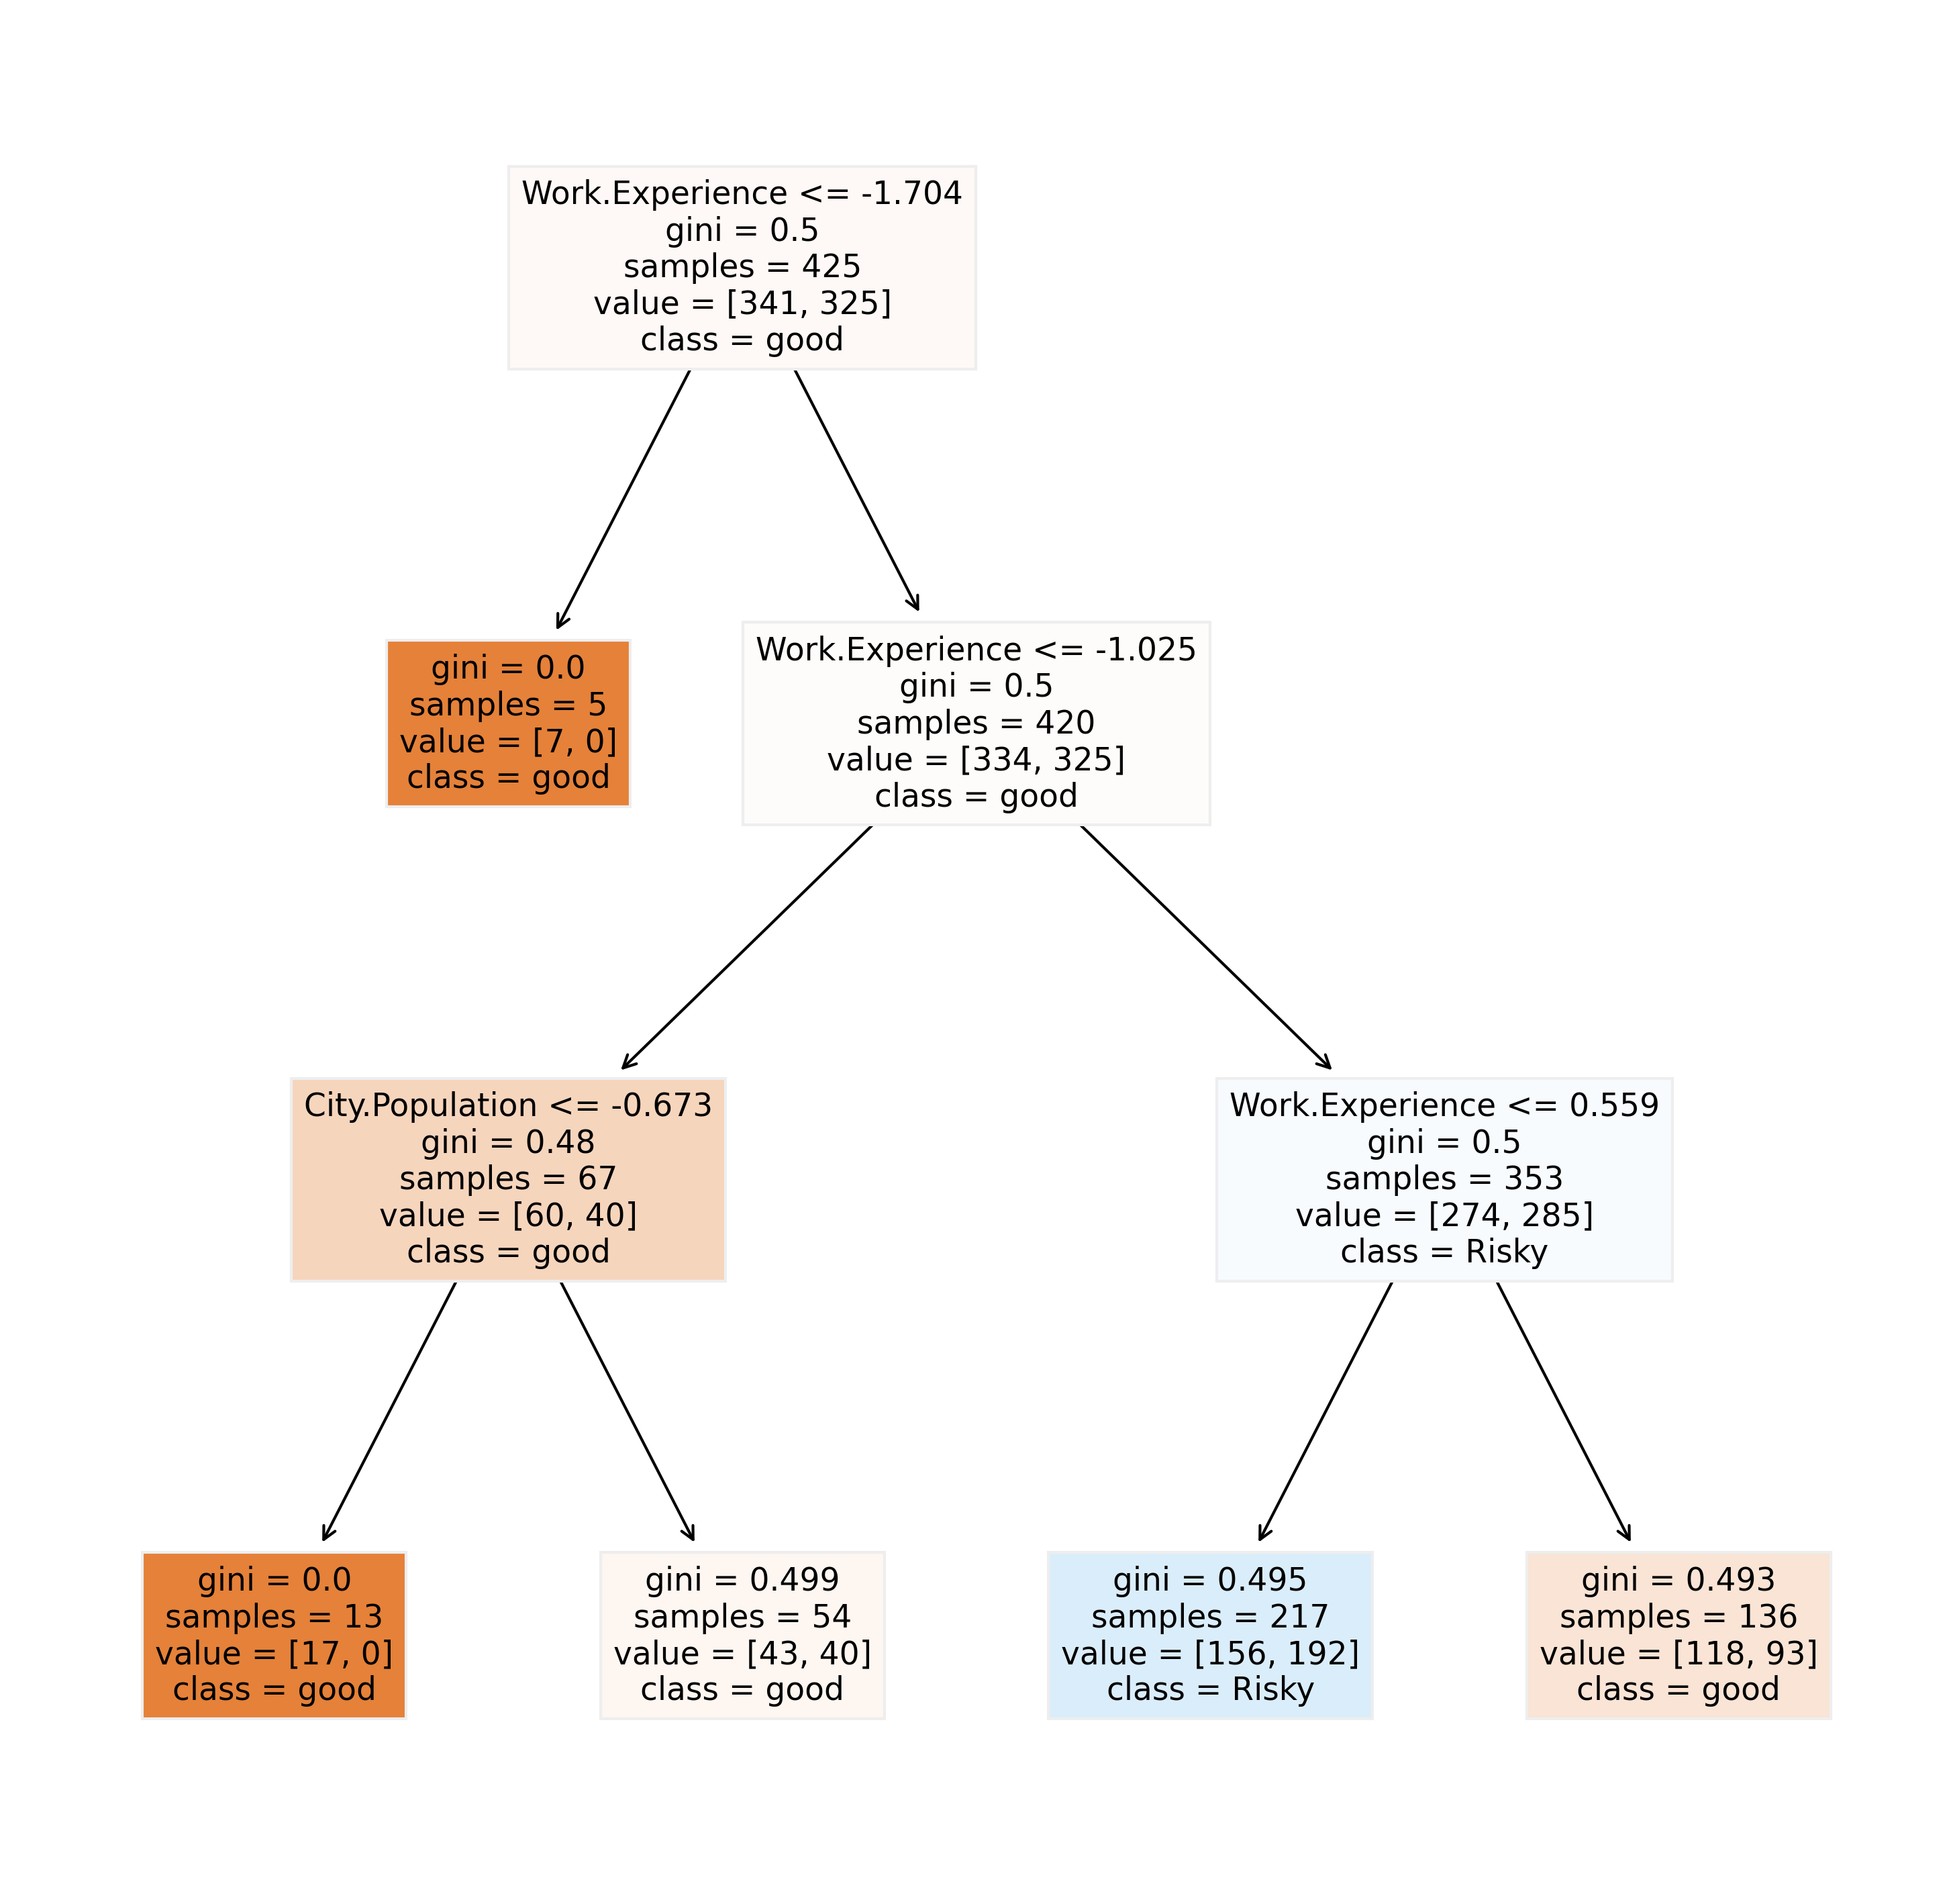

In [70]:
#PLot the decision tree
fn=['City.Population', 'Work.Experience', 'Undergrad', 'Marital.Status', 'Urban']
cn=['good','Risky']


fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (6,6), dpi=600)

tree.plot_tree(model_g.estimators_[19],feature_names = fn, class_names=cn,filled = True);

### Model bulding with RandomForest Regressor

In [96]:
from sklearn.ensemble import RandomForestRegressor
model_reg =RandomForestRegressor(max_depth=3,n_estimators = 200, random_state = 0)
model_reg.fit(x_train,y_train)
pred_test_reg = model_reg.predict(x_test)

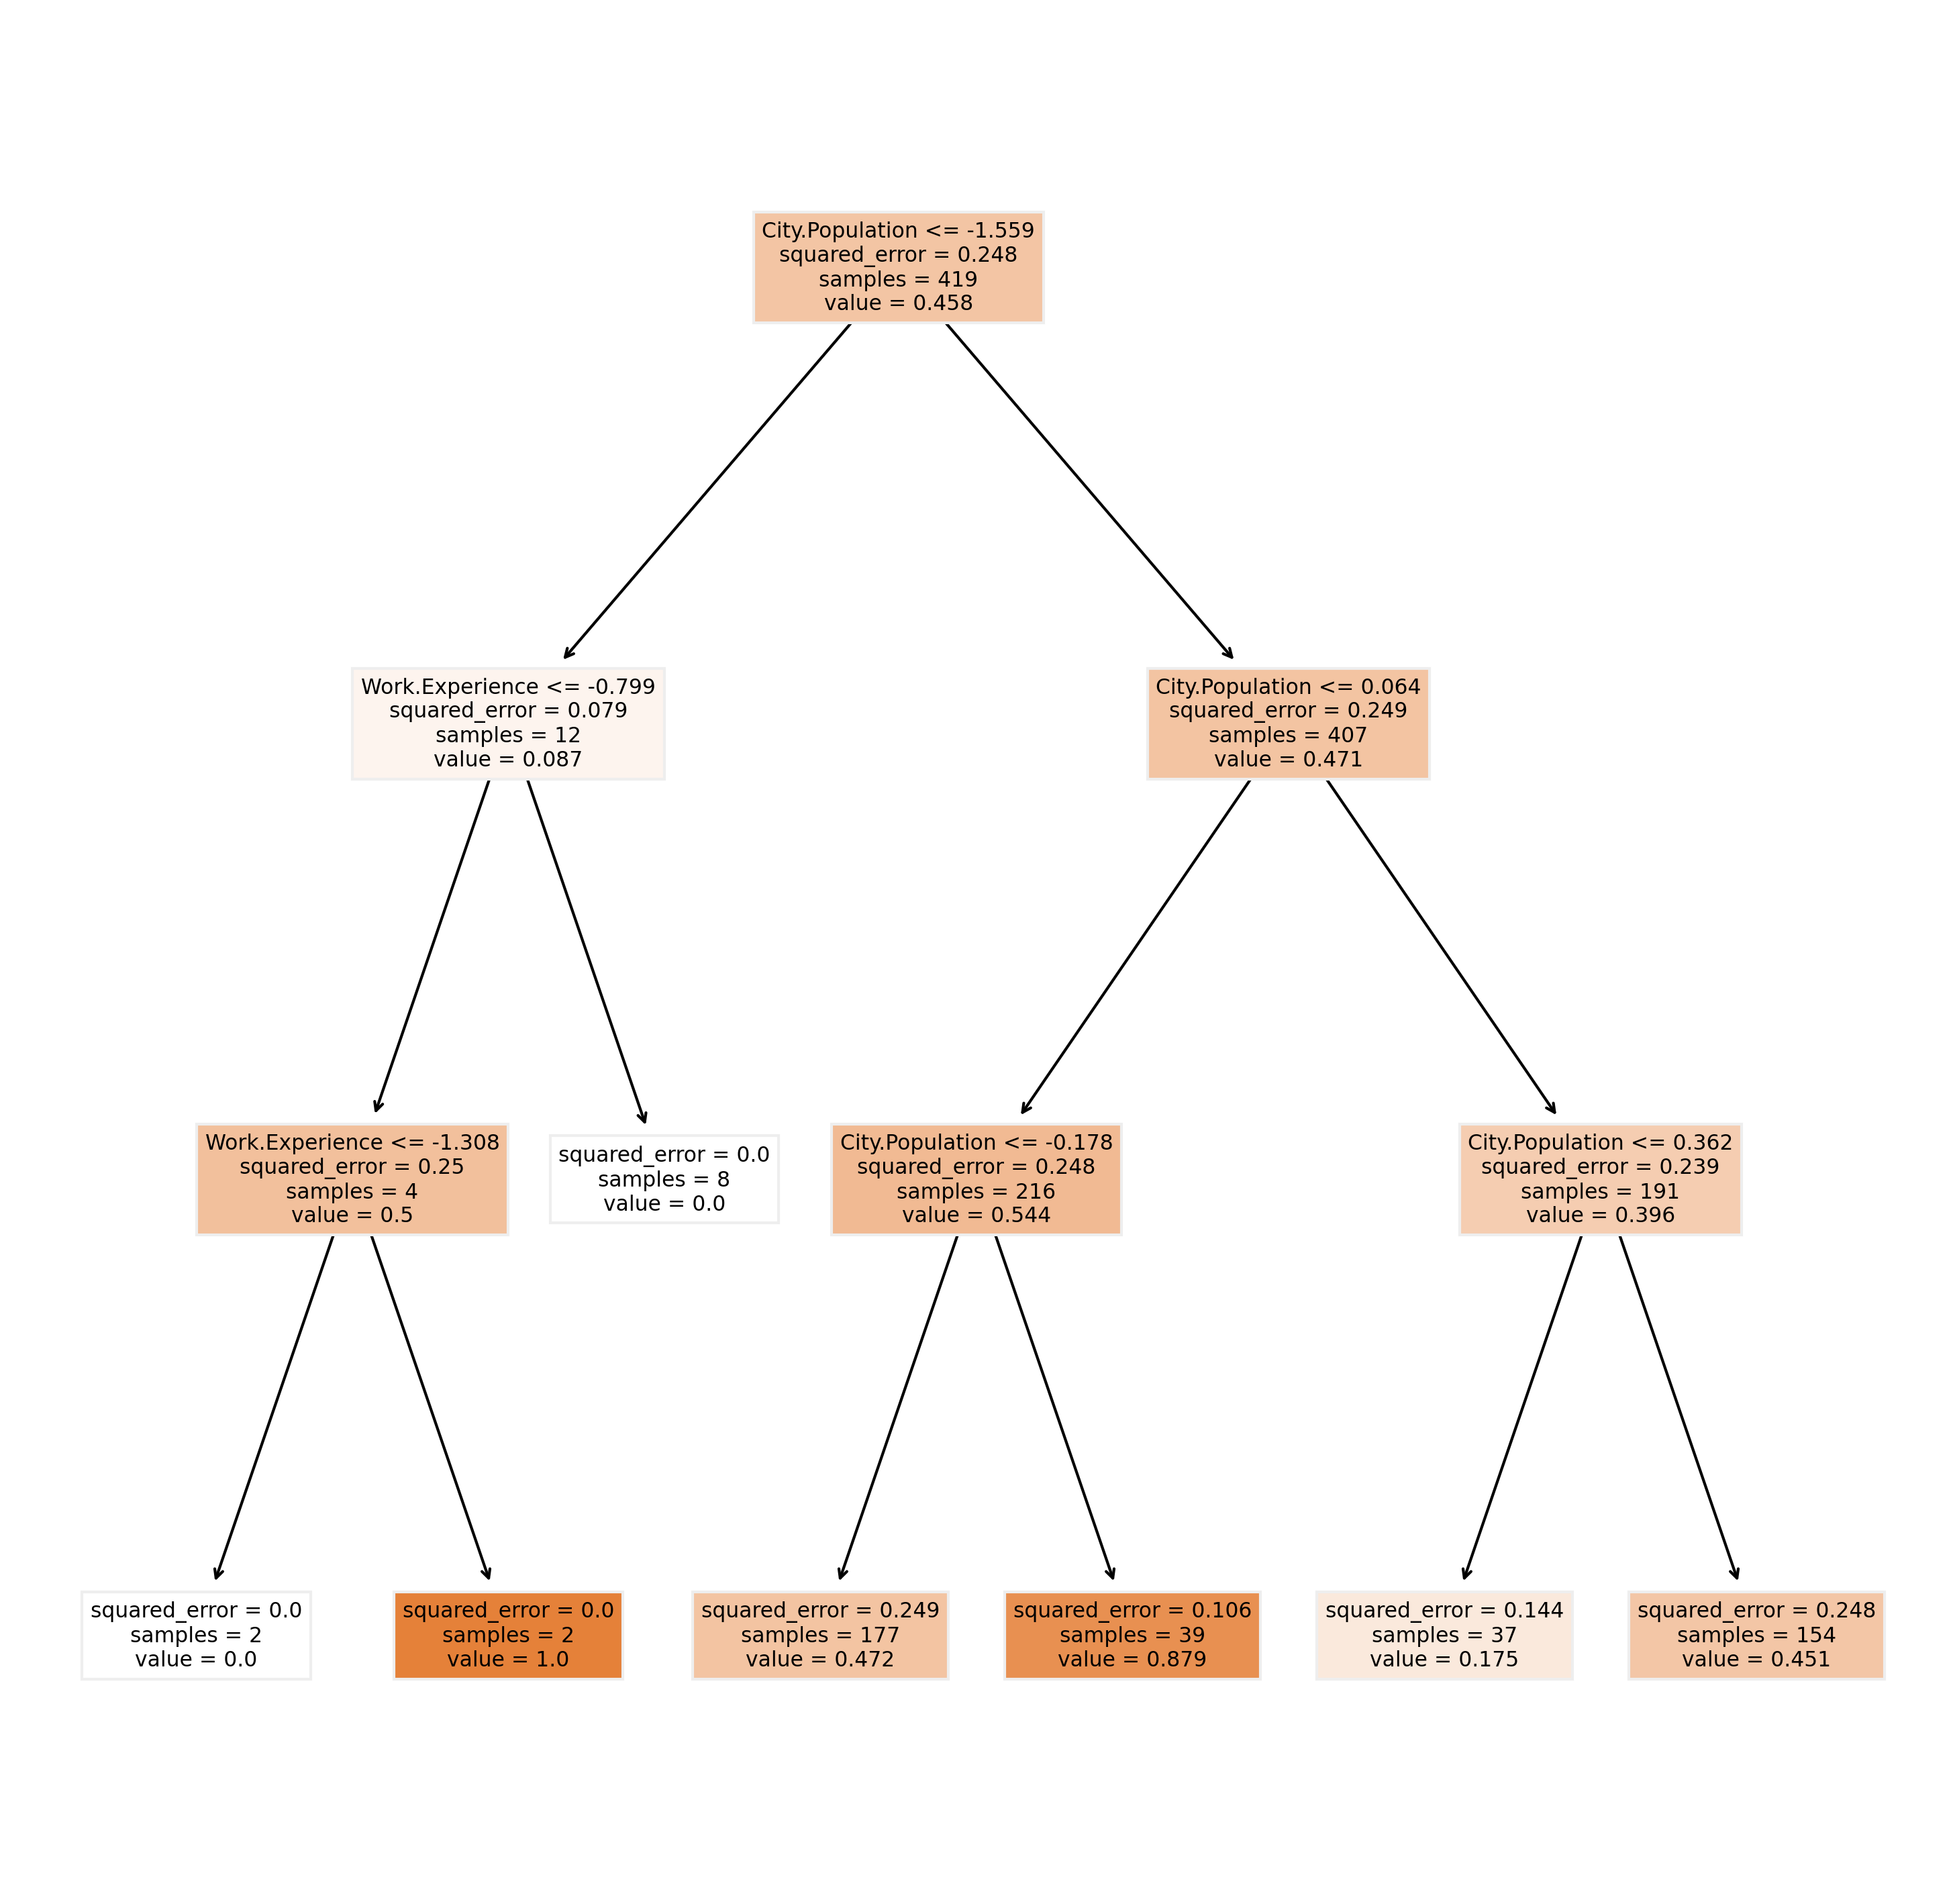

In [103]:
#PLot the decision tree
fn=['City.Population', 'Work.Experience', 'Undergrad', 'Marital.Status', 'Urban']
cn=['good','Risky']


fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (6,6), dpi=600)

tree.plot_tree(model_reg.estimators_[6],feature_names = fn, class_names=cn,filled = True);

### Prediction for new data 

In [109]:
model_g.predict([[134075,18,0,1,1,0,0,0,1]])

array([0])

## Conclusion
+ We have categorice the Taxable_Income in two category high and low
+ we apply different method for balance data and find that randomoversampling gives best result
+ when we tune model with hyperparameters we find that maximum depth is 3.
+ As we show the tree the city pollution has high degree of uncertanity.